<a href="https://colab.research.google.com/github/KaiXiangC/Python_Factor-Investing_Final-Project/blob/main/D1087812_%E7%8E%8B%E6%AD%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **策略715. 盈餘加速成長**

# 1.0 安裝套件 & 環境

In [ ]:
!pip install xgboost
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
#!dpkg -i libta.deb ta.deb
#!pip install ta-lib
!pip install mpl_finance
!pip install mglearn
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

--2023-12-28 16:28:46--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 64.233.189.101, 64.233.189.113, 64.233.189.139, ...
Connecting to drive.google.com (drive.google.com)|64.233.189.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/as715je8ufsbh3pvcku5g8asn4fi6v4l/1703780925000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=17a34940-9406-4ec8-86be-fab34389b417 [following]
--2023-12-28 16:28:51--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/as715je8ufsbh3pvcku5g8asn4fi6v4l/1703780925000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=17a34940-9406-4ec8-86be-fab34389b417
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to doc-0k

In [ ]:
import pandas as pd
import numpy as np
import warnings
from pandas.tseries.offsets import MonthEnd
#------------------機器學習套件-------------------#
import sklearn
# 模型套件
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
# import talib #計算技術指標套件
import matplotlib.pyplot as plt #繪圖套件
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime
import seaborn as sns
import xgboost
from matplotlib import pyplot as plt

#-----------------中文字體------------------------#
import matplotlib as mpl
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

plt.style.use('ggplot')
plt.rcParams.update({
    'font.weight': 'bold',
    'text.color': 'k',
    'axes.labelcolor': 'k',
    'xtick.color': 'k',
    'ytick.color': 'k'})
warnings.simplefilter(action='ignore', category=Warning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_price1 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df_price2 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//加權報酬指數.feather')
df_price3 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//季財報資料.feather')
df_price4 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//月營收資料.feather')
df_price5 = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//籌碼資料.feather')

# 2.0 股票因子計算

In [ ]:
# 證券名稱、資料日、收盤價、成交量、普通股股本、月營收、股東權益總計
df_1 = df_price1[['證券名稱','資料日','收盤價']]
df_2 = df_price3[['證券名稱','編表日','普通股股本','營業利益']]
df_3 = df_price4[['證券名稱','營收發布日','單月營收(千元)']]

df_3['月營收_YoY'] = df_3.groupby('證券名稱').apply(lambda x: (x['單月營收(千元)'] - x['單月營收(千元)'].shift(12)) / x['單月營收(千元)'].shift(12)).reset_index(level=0,drop=True)
# df_2['營利率'] = df_2['營業利益'] / df_2['營業收入']
df_2['營業利益_QoQ'] = df_2.groupby('證券名稱').apply(lambda x: (x['營業利益'] - x['營業利益'].shift(1)) / x['營業利益'].shift(1)).reset_index(level=0,drop=True)

# 3.0 合併各類因子資料
- 根據前一部份計算整理，列出想要放入模型的因子 (需保留`收盤價`欄位)
- 合併部份基本無需更動，確認最後產出之dataframe無缺失值、重複值、inf(無限大值)，且資料合理即可

In [ ]:
# 將價量以外因子(籌碼、月營收、財報因子)，mapping至日頻率
df_3.drop_duplicates(subset=['證券名稱','營收發布日'],inplace=True)
df_3 = df_3.reset_index(drop=True)

df_2.drop_duplicates(subset=['證券名稱','編表日'],inplace=True)
df_2 = df_2.reset_index(drop=True)

df_1['資料日'] = pd.to_datetime(df_1['資料日'])
df_1.set_index('資料日', inplace=True)
df_1 = df_1.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_1 = df_1.sort_values(by=['證券名稱','資料日']).reset_index()

df_3['營收發布日'] = pd.to_datetime(df_3['營收發布日'])
df_3.set_index('營收發布日', inplace=True)
df_3 = df_3.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_3 = df_3.sort_values(by=['證券名稱','營收發布日']).reset_index()

df_2['編表日'] = pd.to_datetime(df_2['編表日'])
df_2.set_index('編表日', inplace=True)
df_2 = df_2.groupby('證券名稱').resample('D').ffill().reset_index(level=0,drop=True)
df_2 = df_2.sort_values(by=['證券名稱','編表日']).reset_index()

In [ ]:
# 以價量資料(台股交易日)為基準，合併不同頻率之資料
df_all_factor = df_1.copy()

# merge: 合併兩個dataframe，on=合併基準欄位，how=以哪個dataframe為準)
df_all_factor = pd.merge(df_all_factor, df_3, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '營收發布日'], how='left')
df_all_factor = pd.merge(df_all_factor, df_2, left_on=['證券名稱', '資料日'], right_on=['證券名稱', '編表日'], how='left')

df_all_factor.drop(columns=['營收發布日','編表日'],inplace=True)

In [ ]:
# 把inf(除以0)填補成缺失值，以利後續一併刪除
df_all_factor.replace([np.inf, -np.inf], np.NaN, inplace=True)

# 刪除含有缺失值之資料行
df_all_factor.dropna(inplace=True)
df_all_factor = df_all_factor.sort_values(by=['證券名稱','資料日']).reset_index(level=0,drop=True)

## 數據圖繪製

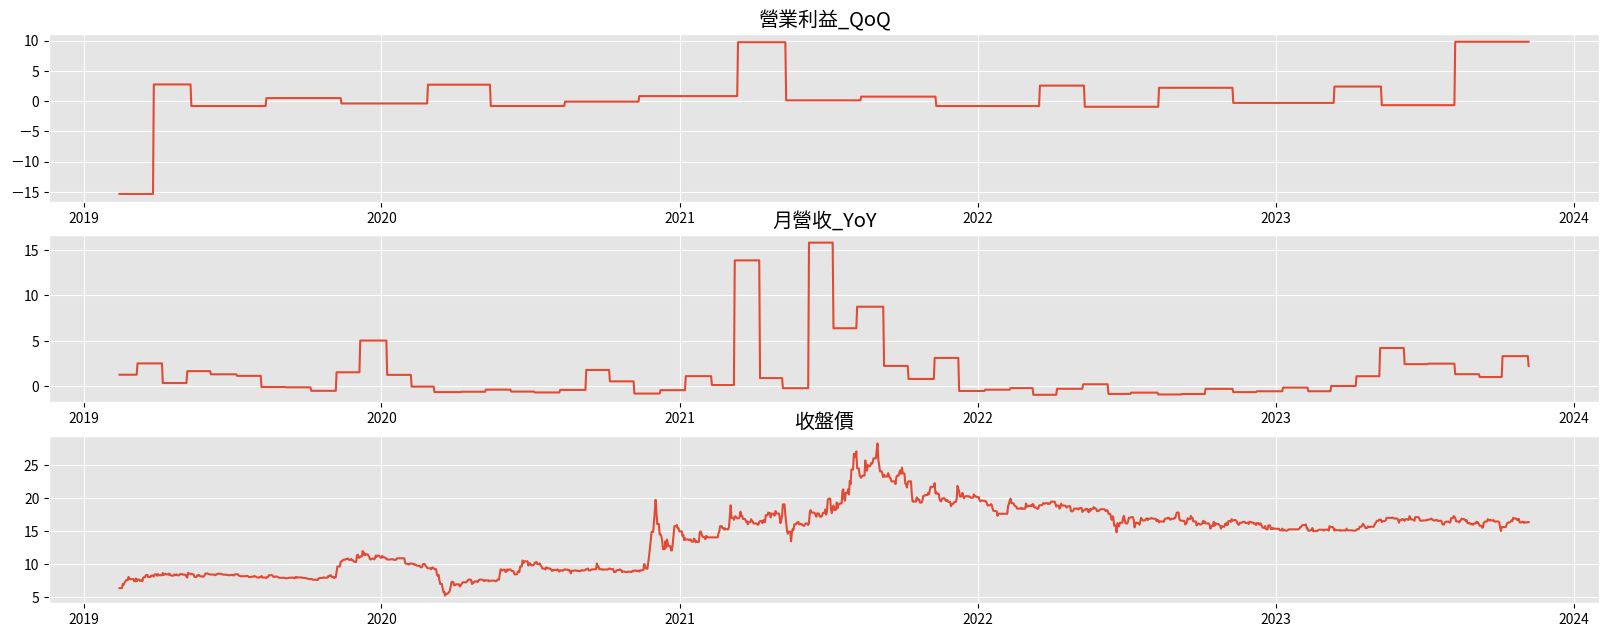

In [ ]:
df_data_train_plot = df_all_factor[df_all_factor['證券名稱'] == '1456怡華'].copy()

plt.figure(figsize=(20,10))
ax1 = plt.subplot(4,1,1)
plt.title('營業利益_QoQ')
plt.plot(df_data_train_plot['資料日'],df_data_train_plot['營業利益_QoQ'])

ax2 = plt.subplot(4,1,2)
plt.title('月營收_YoY')
plt.plot(df_data_train_plot['資料日'],df_data_train_plot['月營收_YoY'])

ax3 = plt.subplot(4,1,3)
plt.title('收盤價')
plt.plot(df_data_train_plot['資料日'],df_data_train_plot['收盤價'])

In [ ]:
# 依據各指標特性，制定篩選規則
df_select = df_all_factor.copy()

# 2.股本<20億、收盤價<70、連續三季營業利益成長、連續兩個月YoY>1%
df_select = df_select[(df_all_factor['普通股股本']<=2000000) & (df_all_factor['收盤價']<=70) & (df_all_factor['月營收_YoY']>1) & (df_all_factor['月營收_YoY'].shift(1)>1) & (df_all_factor['營業利益']>=df_all_factor['營業利益'].shift(1))& (df_all_factor['營業利益'].shift(1)>=df_all_factor['營業利益'].shift(2))]

# 3.按營業利益排序，每月選出前15名個股
df_select = df_select.groupby('資料日').apply(lambda x: x.sort_values(by='營業利益', ascending=False).head(15))

df_select.reset_index(drop=True, inplace=True)

# 抽樣驗證
df_select[df_select['資料日']=='2023-11-01']

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ
25811,2023-11-01,2718晶悅,45.100000,85014.0,10.726069,875760.0,345458.0,0.155486
25812,2023-11-01,5523豐謙,25.100000,119878.0,83.540197,1550015.0,248580.0,0.591442
25813,2023-11-01,1456怡華,16.250000,216090.0,3.316793,937200.0,220056.0,9.806128
25814,2023-11-01,1603華電,33.500000,621451.0,1.404335,1916880.0,127811.0,0.666462
25815,2023-11-01,6219富旺,19.978345,364772.0,4.118099,940163.0,123012.0,-4.253941
25816,2023-11-01,8473山林水,27.100000,323820.0,1.462940,1470040.0,99528.0,0.364425
25817,2023-11-01,6122擎邦,46.600000,427280.0,1.155052,722068.0,99023.0,0.487524
25818,2023-11-01,6148驊宏資,30.250000,122696.0,1.451175,466038.0,46680.0,5.868746
25819,2023-11-01,5706鳳凰,68.800000,230018.0,10.613551,737670.0,42195.0,0.223646
25820,2023-11-01,4760勤凱,67.900000,100286.0,1.183596,318401.0,41670.0,0.737336


In [ ]:
# 每日選股名單
df_select_d = df_select[['資料日','證券名稱','收盤價']].sort_values(by=['資料日','證券名稱'])

# 每月第一個交易日之選股名單
df_select_d['年月'] = df_select_d['資料日'].dt.strftime('%Y-%m')
reb_date = df_select_d[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_select_m = df_select_d[df_select_d['資料日'].isin(reb_date['資料日'])].copy().reset_index(drop=True)

df_select_m[df_select_m['資料日']=='2023-11-01']

,資料日,證券名稱,收盤價,年月
842,2023-11-01,1456怡華,16.250000,2023-11
843,2023-11-01,1603華電,33.500000,2023-11
844,2023-11-01,2718晶悅,45.100000,2023-11
845,2023-11-01,2734易飛網,41.050000,2023-11
846,2023-11-01,4760勤凱,67.900000,2023-11
847,2023-11-01,5432新門,61.200000,2023-11
848,2023-11-01,5523豐謙,25.100000,2023-11
849,2023-11-01,5706鳳凰,68.800000,2023-11
850,2023-11-01,6122擎邦,46.600000,2023-11
851,2023-11-01,6148驊宏資,30.250000,2023-11


# 4.0 AdaBoost選股模型

In [ ]:
# 特徵集合(因子集合)
feature_list = df_all_factor.columns.drop(['證券名稱','資料日','收盤價','普通股股本'])

# 取每月第一個交易日的資料
df_feature = df_all_factor.copy()
df_feature['年月'] = df_feature['資料日'].dt.strftime('%Y-%m')
reb_date_all = df_feature[['年月','資料日']].sort_values(by='資料日').drop_duplicates(subset=['年月'], keep = 'first').reset_index(drop=True)
df_feature_m = df_feature[df_feature['資料日'].isin(reb_date_all['資料日'])].copy().reset_index(drop=True)

In [ ]:
# 因子標準化
def standardize(x):
    return (x - x.mean()) / x.std()

df_feature_m[feature_list] = df_feature_m.groupby('資料日')[feature_list].apply(standardize).reset_index(level=0,drop=True)
df_feature_m.head()

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ,年月
0,2019-03-01,1101台泥,24.444250,0.604688,-0.030092,51080599.0,2.138930,0.027591,2019-03
1,2019-04-01,1101台泥,26.322128,0.448883,-0.045742,53080599.0,2.033372,0.015895,2019-04
2,2019-05-01,1101台泥,26.735898,0.802731,-0.040875,53080599.0,2.037005,0.011265,2019-05
3,2019-06-01,1101台泥,27.308810,0.775974,-0.026439,51080599.0,2.350363,-0.028264,2019-06
4,2019-07-01,1101台泥,29.377659,0.787658,-0.031428,51080599.0,2.348776,-0.028267,2019-07


In [ ]:
# 計算個股下期報酬，作為模型訓練答案

df_feature_m['下期報酬'] = df_feature_m.groupby('證券名稱').apply(lambda x:(x['收盤價'].shift(-1)/x['收盤價']-1)*0.2 +x['月營收_YoY']*0.4 +x['營業利益_QoQ']*0.4).reset_index(level=0,drop=True)
df_feature_m.dropna(inplace=True)
df_feature_m[df_feature_m['證券名稱'] == '1101台泥'].tail()

,資料日,證券名稱,收盤價,單月營收(千元),月營收_YoY,普通股股本,營業利益,營業利益_QoQ,年月,下期報酬
51,2023-06-01,1101台泥,37.23777,0.585962,-0.040397,71561817.0,-0.046479,0.025234,2023-06,-0.004476
52,2023-07-01,1101台泥,37.53370,0.585032,-0.032134,71561817.0,-0.046385,0.025181,2023-07,-0.002694
53,2023-08-01,1101台泥,37.55000,0.542795,0.017515,71561817.0,-0.047155,0.025027,2023-08,0.004766
54,2023-09-01,1101台泥,35.25000,0.510289,-0.027184,71561817.0,0.545483,1.513896,2023-09,0.583337
55,2023-10-01,1101台泥,33.25000,0.577062,-0.060160,71561817.0,0.546092,1.514828,2023-10,0.574950


In [ ]:
# 切分訓練期和測試期
train_start_st = '2020-01-01'
test_start_st= '2022-01-01'
test_end_dt = '2023-11-30'
df_train = df_feature_m[df_feature_m['資料日'] >= train_start_st]
df_train = df_train[df_train['資料日'] < test_start_st]
df_test = df_feature_m[df_feature_m['資料日'] >= test_start_st]
df_test = df_test[df_test['資料日'] <= test_end_dt]

##################
# 每期選幾檔股票(可調整)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            portfolio_stock_num = 15
##################

# 模型訓練及選股
# model = xgboost.XGBRegressor()
#model = DecisionTreeRegressor(max_depth=3)
model = AdaBoostRegressor()
model.fit(df_train[feature_list],df_train['下期報酬'])

df_test['模型預測分數'] = model.predict(df_test[feature_list])
#df_test = df_test[(df_test['普通股股本']<=2000000) & (df_test['收盤價']<=70)]
df_test = df_test.sort_values(['資料日','模型預測分數'],ascending=[1,0])
df_select = df_test.groupby('資料日').apply(lambda x : x.head(portfolio_stock_num)).reset_index(drop=True)[['資料日','證券名稱','收盤價']]
df_select[df_select['資料日']=='2022-11-01']

,資料日,證券名稱,收盤價
150,2022-11-01,1453大將,13.735348
151,2022-11-01,3056富華新,19.294124
152,2022-11-01,6576逸達,73.207130
153,2022-11-01,2530華建,17.294882
154,2022-11-01,5523豐謙,23.962258
155,2022-11-01,6596寬宏藝術,39.823834
156,2022-11-01,8097常珵,53.637465
157,2022-11-01,3713新晶投控,24.950000
158,2022-11-01,8038長園科,34.835284
159,2022-11-01,3522御頂,10.650000


Text(0.5, 1.0, 'AdaBoostRegressor')

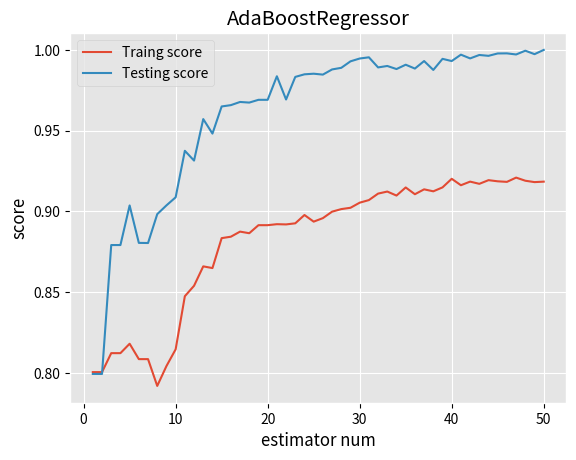

In [ ]:

plt=plt.figure().add_subplot(1,1,1)
estimators_num=len(model.estimators_)
X=range(1,estimators_num+1)
plt.plot(list(X),list(model.staged_score(df_train[feature_list],df_train['下期報酬'])),label="Traing score")
plt.plot(list(X),list(model.staged_score(df_test[feature_list],df_test['模型預測分數'])),label="Testing score")
plt.set_xlabel("estimator num")
plt.set_ylabel("score")
plt.legend(loc="best")
plt.set_title("AdaBoostRegressor")


# 5.0 投組績效回測

In [ ]:
# 讀取價格資料，進行整理
df = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//價量資料.feather')
df.sort_values(by=['證券名稱', '資料日'], ascending=True, inplace=True)
df.drop_duplicates(subset=['證券名稱', '資料日'], keep='last', inplace=True)
df['資料日'] = pd.to_datetime(df['資料日'])
df.set_index('資料日', inplace=True)
df.head()

,證券名稱,市場別,開盤價,最高價,最低價,收盤價,成交量(千股),成交金額(元),成交筆數,周轉率,流通在外股數(千股),個股市值(元),市值比重,成交金額比重,現金股利率(TEJ),本益比(TEJ),股價淨值比(TEJ),股價營收比(TEJ)
資料日,,,,,,,,,,,,,,,,,,
2018-01-02,1101台泥,TWSE,36.45,36.60,36.05,20.444681,13698.0,4.993709e+08,3932.0,0.3226,4246509.0,1.552099e+11,0.485348,0.522,3.45,20.26,1.38,1.63
2018-01-03,1101台泥,TWSE,36.50,37.35,36.25,20.892171,19959.0,7.373536e+08,5001.0,0.4700,4246509.0,1.586071e+11,0.491803,0.565,3.38,20.71,1.41,1.66
2018-01-04,1101台泥,TWSE,37.35,37.45,36.75,20.808266,14927.0,5.553930e+08,5698.0,0.3515,4246509.0,1.579701e+11,0.487705,0.414,3.39,20.62,1.41,1.65
2018-01-05,1101台泥,TWSE,37.50,37.50,37.05,20.864203,35536.0,1.325927e+09,7554.0,0.8368,4246509.0,1.583948e+11,0.487621,0.992,3.38,20.68,1.41,1.66
2018-01-08,1101台泥,TWSE,37.40,38.30,37.20,21.367628,22660.0,8.585742e+08,7513.0,0.5336,4246509.0,1.622166e+11,0.497755,0.659,3.30,21.18,1.45,1.70


## 5.1 選股投組回測

In [ ]:
# 每月初收盤價
monthly_st_price = df.groupby('證券名稱').resample('M')['收盤價'].first().unstack().transpose()

# 每月底收盤價
monthly_end_price = df.groupby('證券名稱').resample('M')['收盤價'].last().unstack().transpose()

# 這個月初到這個月底的報酬
monthly_returns = monthly_end_price/monthly_st_price - 1
# monthly_returns = monthly_end_price.pct_change()

print(monthly_returns.shape)
monthly_returns.head()

(71, 1759)


證券名稱,1101台泥,1102亞泥,1103嘉泥,1104環泥,1108幸福,1109信大,1110東泥,1201味全,1203味王,1210大成,...,9944新麗,9945潤泰新,9946三發地產,9949琉園,9950萬國通,9951皇田,9955佳龍,9958世紀鋼,9960邁達康,9962有益
資料日,,,,,,,,,,,,,,,,,,,,,
2018-01-31,0.030096,0.065603,0.007435,-0.006522,0.010714,0.026022,-0.044369,0.116390,0.057312,0.010401,...,0.002545,0.045313,-0.033457,-0.017857,0.003676,-0.116959,-0.068323,0.873391,-0.038514,0.014563
2018-02-28,-0.023747,-0.053333,-0.069853,-0.017505,-0.018935,0.032491,-0.003559,-0.056723,-0.022472,0.004438,...,0.010178,-0.028701,-0.015326,-0.031963,-0.054945,-0.042763,-0.105085,0.302083,-0.063291,0.028846
2018-03-31,-0.012162,0.012411,-0.075397,0.000000,-0.053528,-0.003521,0.003584,0.093960,0.003817,-0.011445,...,-0.015113,0.049231,0.031128,-0.018868,0.027132,-0.047945,0.022222,0.267717,0.035556,-0.018349
2018-04-30,0.114598,0.106272,0.004202,-0.015660,-0.011673,-0.014286,0.000000,-0.024845,-0.013410,0.103597,...,-0.015345,0.045455,0.069597,-0.004739,-0.065385,0.003597,0.003636,-0.105263,-0.046617,0.009174
2018-05-31,0.067319,0.031201,0.112971,-0.040909,0.061438,-0.007194,-0.007168,0.012712,0.005848,0.026490,...,-0.010390,0.004167,-0.017422,-0.038095,0.012097,-0.153571,-0.051095,-0.250000,-0.033762,-0.013575


In [ ]:
# 設定回測期間
start_dt = '2022-01-01'
end_dt = '2023-11-30'

# 換倉日
reb_date = df_select_m[(df_select_m['資料日'] > start_dt) & (df_select_m['資料日'] < end_dt)]['資料日'].unique()

# 計算投組每月報酬
portfolio_return = []
for i in range(len(reb_date)):
    reb_ticker_list = df_select_m[df_select_m['資料日'] == reb_date[i]]['證券名稱'].values
    mean_return = np.mean(monthly_returns[reb_ticker_list].loc[reb_date[i] + MonthEnd(n=0)])
    portfolio_return.append(mean_return)

# 計算投組累積報酬
portfolio_return = np.insert(portfolio_return,0,[0]) #起始日報酬為0
portfolio_return = np.array(portfolio_return) + 1
portfolio_cumulative_return = portfolio_return.cumprod()

df_portfolio_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_portfolio_tr['Portfolio Return'] = portfolio_return - 1
df_portfolio_tr['Portfolio Total Return'] = portfolio_cumulative_return
print(len(df_portfolio_tr))
df_portfolio_tr.head()

23


,Portfolio Return,Portfolio Total Return
2022-01-31,0.000000,1.000000
2022-02-01,-0.017115,0.982885
2022-03-01,0.050063,1.032091
2022-04-01,-0.026334,1.004912
2022-05-01,-0.051787,0.952870


## 5.2 加權報酬指數回測(Benchmark)

In [ ]:
# 讀取Benchmark資料
benchmark = pd.read_feather('/content/drive/MyDrive/FCU_20231208/Data//加權報酬指數.feather')
benchmark.set_index('資料日',inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)

# 每月初收盤價
monthly_st_price_bm = benchmark.resample('M')['收盤價'].first()
# 每月底收盤價
monthly_end_price_bm = benchmark.resample('M')['收盤價'].last()

# 這個月初到這個月底的報酬
# monthly_returns_bm = monthly_end_price_bm.pct_change()
monthly_returns_bm = monthly_end_price_bm/monthly_st_price_bm - 1
monthly_returns_bm = monthly_returns_bm.loc[[i + MonthEnd(n=0)for i in reb_date]]

# 計算Benchmark累積報酬
monthly_returns_bm = np.insert(np.array(monthly_returns_bm),0,[0]) #起始日報酬為0
monthly_returns_bm = np.array(monthly_returns_bm) + 1
bm_portfolio_tr = monthly_returns_bm.cumprod()

df_benchmark_tr = pd.DataFrame(index = np.insert(reb_date,0,reb_date[0]-MonthEnd(n=1)))
df_benchmark_tr['Benchmark Return'] = monthly_returns_bm - 1
df_benchmark_tr['Benchmark Total Return'] = bm_portfolio_tr
df_benchmark_tr

print(len(df_benchmark_tr))
df_benchmark_tr.head()

23


,Benchmark Return,Benchmark Total Return
2022-01-31,0.000000,1.000000
2022-02-01,-0.013786,0.986214
2022-03-01,-0.009513,0.976833
2022-04-01,-0.058098,0.920081
2022-05-01,0.018823,0.937400


## 績效呈現

,Portfolio Total Return,Benchmark Total Return
最大回撤,-0.185293,-0.191564
累積報酬,1.329763,1.058540
年化報酬,0.160320,0.030127
Sharpe Ratio,0.651656,0.153376


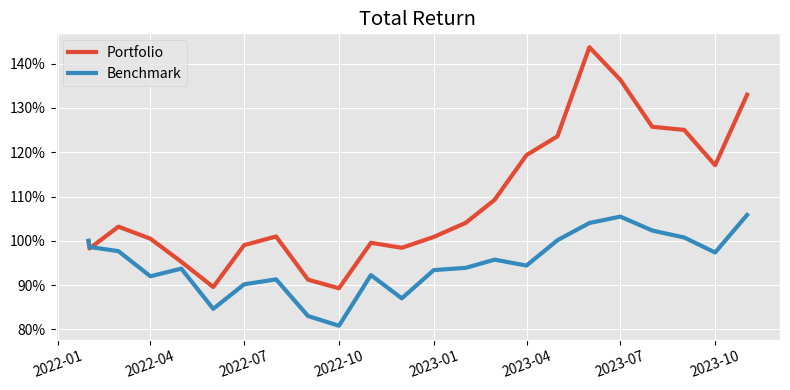

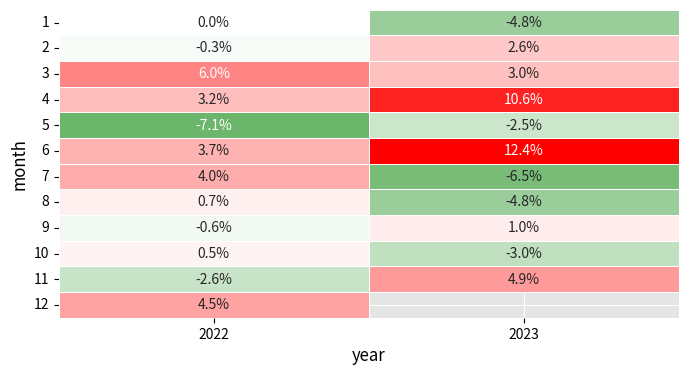

In [ ]:
# 績效指標
def perf_cal(df_tr, name_1, name_2):
    status = {}
    status['最大回撤'] = -((df_tr[name_1].cummax() - df_tr[name_1])/df_tr[name_1].cummax()).max()
    status['累積報酬'] = [df_tr[name_1].iloc[-1]]
    status['年化報酬'] = [(df_tr[name_1].iloc[-1] ** (12/len(df_tr))-1)]
    std = df_tr[name_2].std() * np.sqrt(12)
    status['Sharpe Ratio'] = status['年化報酬'] / std
    status = pd.DataFrame(status).transpose()
    status.columns = [name_1]
    return status

# 累積報酬圖
def plot_total_return(df_portfolio_tr,df_benchmark_tr, name):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(df_portfolio_tr.index, df_portfolio_tr['Portfolio Total Return'], label='Portfolio', linewidth=3)
    ax.plot(df_benchmark_tr.index, df_benchmark_tr['Benchmark Total Return'], label='Benchmark', linewidth=3)
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1))
    plt.legend(loc='upper left')
    plt.title('Total Return')
    plt.xticks(rotation=20)
    plt.tight_layout()

# 月度勝率圖
def plot_monthly_return(df_portfolio_tr, df_benchmark_tr):
    df_portfolio_tr['year'] = df_portfolio_tr.index.year
    df_portfolio_tr['month'] = df_portfolio_tr.index.month
    df_benchmark_tr['year'] = df_benchmark_tr.index.year
    df_benchmark_tr['month'] = df_benchmark_tr.index.month
    rt_pivot_strategy = df_portfolio_tr.pivot(index='year', columns='month', values='Portfolio Return')
    rt_pivot_benchmark = df_benchmark_tr.pivot(index='year', columns='month', values='Benchmark Return')
    rt_pivot_excess = rt_pivot_strategy - rt_pivot_benchmark

    cmap1= LinearSegmentedColormap.from_list("custom", [(0, "green"), (0.5, "white"), (1, "red")])
    fig, ax = plt.subplots(figsize=(8,4))
    sns.heatmap(rt_pivot_excess.T,annot=True, xticklabels= True, yticklabels= True, cmap=cmap1, center=0, fmt='.1%', cbar=False, linewidths=0.5)
    plt.yticks(rotation=0)


# 呼叫績效呈現函式
plot_total_return(df_portfolio_tr,df_benchmark_tr, 'Portfolio_1')
plot_monthly_return(df_portfolio_tr, df_benchmark_tr)
portfolio_perf = perf_cal(df_portfolio_tr, 'Portfolio Total Return','Portfolio Return')
benchmark_perf = perf_cal(df_benchmark_tr, 'Benchmark Total Return','Benchmark Return')
summary_perf = pd.concat([portfolio_perf,benchmark_perf],axis=1)
summary_perf